In [373]:
from qiskit import *
from qiskit.quantum_info import Pauli, SparsePauliOp, Statevector
import itertools
from qiskit.opflow import PauliSumOp
from qiskit.circuit.library import PauliEvolutionGate
from VQE_CVaR import VQE, partition_N
import numpy as np
from qiskit import Aer, QuantumRegister, QuantumCircuit
import itertools

from math import cos, sin, cosh, sinh, atan, exp, pi, sqrt
from scipy.optimize import minimize

import sys

In [309]:
def find_light_cone(pairs):
    lightcone_dict = {}
    for index, list in enumerate(pairs):
        print('column', index, 'gates', list)
        for pair in list:
            qi, qj = pair
            relevent_pairs = []  ##  qubit pairs in the previous layer that in the lightcone of the current pair
            if index > 0:
                for pair_layerm1 in pairs[index-1]: ## qubit pairs in the previous layer
                    if (qi in pair_layerm1) or (qj in pair_layerm1):
                        relevent_pairs.append(pair_layerm1)
            lightcone_dict[pair] = relevent_pairs
    return lightcone_dict

In [5]:
backend = Aer.get_backend('aer_simulator')  #lo uso??

In [6]:
N = 4
tau = 0.2


In [310]:
edges_columns = partition_N(N)
print('edges_columns', edges_columns)
lightcone_dict = find_light_cone(edges_columns)
print('lightcone_dict', lightcone_dict)
pairs_all = list(itertools.chain.from_iterable(partition_N(N)))
num_pairs = len(pairs_all)
print('num pairs:', num_pairs)
print('pairs:', pairs_all)

edges_columns [[(0, 1), (2, 3)], [(0, 3)], [(1, 3), (0, 2)], [(1, 2)]]
column 0 gates [(0, 1), (2, 3)]
column 1 gates [(0, 3)]
column 2 gates [(1, 3), (0, 2)]
column 3 gates [(1, 2)]
lightcone_dict {(0, 1): [], (2, 3): [], (0, 3): [(0, 1), (2, 3)], (1, 3): [(0, 3)], (0, 2): [(0, 3)], (1, 2): [(1, 3), (0, 2)]}
num pairs: 6
pairs: [(0, 1), (2, 3), (0, 3), (1, 3), (0, 2), (1, 2)]


In [149]:
#just to test 
edge_coeff_dict = {}

edge_coeff_dict.update({(i,): h_val for i, h_val in enumerate(np.random.random(N))})
print(edge_coeff_dict)

for keys,values in lightcone_dict.items():
    print(keys)
    edge_coeff_dict[keys] = np.random.random()
        
print(edge_coeff_dict)


{(0,): 0.27351388441025526, (1,): 0.8989719174466637, (2,): 0.4494685631678199, (3,): 0.3239085852970457}
(0, 1)
(2, 3)
(0, 3)
(1, 3)
(0, 2)
(1, 2)
{(0,): 0.27351388441025526, (1,): 0.8989719174466637, (2,): 0.4494685631678199, (3,): 0.3239085852970457, (0, 1): 0.527901487097946, (2, 3): 0.07554561423979234, (0, 3): 0.16638987875003242, (1, 3): 0.7995870674464222, (0, 2): 0.83731013200203, (1, 2): 0.9620044823230449}


In [150]:
# print('eigens_ids', eigens_ids)
q = QuantumRegister(N, name = 'q')
circ = QuantumCircuit(q)
circ.clear()
circ.h(q[::])

 
params_list = []
edge_params_dict = {} ## to save the initial parameters for each vertex or edge in l'th layer

# Z term
for i in range(N):

    #para = get_initial_para_1op_Y(N, [i], edge_coeff_dict[(i,)], tau, circ, shots, approximation)[0] #use this to extimate para from min expectation value
    tauc = tau * edge_coeff_dict[(i,)] 
    para = 2*atan( -exp(-2*tauc) ) + pi/2 #use this to use analytic formula (only valid for 1 layer)

    edge_params_dict[(i,)] = para
    params_list.append(para)
    circ.ry(para, i)

In [10]:
print('params_list:', params_list)

params_list: [0.1790800077962451, 0.016116063084088417, 0.24105768418885232, 0.04966857613584397]


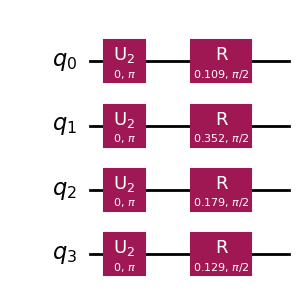

In [151]:
circ.decompose().draw("mpl", style="iqp")

In [12]:
print(Statevector(circ))

Statevector([0.19121711+0.j, 0.22893873+0.j, 0.19432388+0.j,
             0.23265838+0.j, 0.24391902+0.j, 0.2920372 +0.j,
             0.24788205+0.j, 0.29678203+0.j, 0.20095852+0.j,
             0.24060184+0.j, 0.20422356+0.j, 0.24451098+0.j,
             0.25634528+0.j, 0.30691481+0.j, 0.26051021+0.j,
             0.31190136+0.j],
            dims=(2, 2, 2, 2))


In [152]:
# def cost_function(edge,coeff, paras,tau, qcirc):
def cost_function(paras :list, *args):

    edge = args[0]
    coeff = args[1]
    tau = args[2]
    qcirc = args[3]

    state = Statevector(qcirc)
    state2 = Statevector(qcirc)


    tauc = tau * coeff

    print(keys)
    i = min(edge)
    j = max(edge)

    # print('min', i, 'max', j)

    zzop = SparsePauliOp.from_sparse_list([('ZZ', [j, i], -sinh(tauc) )], N)
    zzop += SparsePauliOp.from_list([("I"*N, cosh(tauc))])

    # print('zzop', zzop)
    
    state = state.evolve(zzop)
    
    # print(state)

    # Normalize the state vector manually
    norm = np.linalg.norm(state.data)
    state = state / norm

    # Print the normalized state vector
    print("Normalized state:", state)

    #dovrebbe essere theta mezzi!!

    zyop = SparsePauliOp.from_sparse_list([('ZY', [j, i], -1j*sin(paras[0]/2))], N)
    zyop += SparsePauliOp.from_list([("I"*N, cos(paras[0]/2))])

    # print('zyop', zyop)

    yzop = SparsePauliOp.from_sparse_list([('YZ', [j, i], -1j*sin(paras[1]/2))], N)
    yzop += SparsePauliOp.from_list([("I"*N, cos(paras[1]/2))])

    # print('yzop', yzop)

    op = zyop.compose(yzop)
    # print('op', op)
    
    state2 = state2.evolve(op)
    
    print('states2', state2)

    # Compute the scalar product (inner product) between the two state vectors
    inner_product = state.inner(state2)

    # Compute the square modulus of the inner product
    square_modulus = abs(inner_product)**2

    # Print the inner product and its square modulus
    # print("Inner product:", inner_product)
    print("Square modulus of the inner product:", square_modulus)

    return -square_modulus

    

In [234]:
def circuit_update_zz(Edge,State, Tauc):
    i = min(Edge)
    j = max(Edge)

    zzop = SparsePauliOp.from_sparse_list([('ZZ', [j, i], -sinh(Tauc) )], N)
    zzop += SparsePauliOp.from_list([("I"*N, cosh(Tauc))])
    
    State = State.evolve(zzop)

    # Normalize the state vector manually
    norm = np.linalg.norm(State.data)
    State = State / norm

    # Print the normalized state vector
    # print("Normalized state:", State)

    return State

In [235]:
def circuit_update_theta(Edge, State, paras):
    
    j = min(Edge)    #I SWAPPED i AND j TO MATCH WITH YAHUI CIRCUIT
    i = max(Edge)

    zyop = SparsePauliOp.from_sparse_list([('ZY', [j, i], -1j*sin(paras[0]/2))], N)
    zyop += SparsePauliOp.from_list([("I"*N, cos(paras[0]/2))])

    yzop = SparsePauliOp.from_sparse_list([('YZ', [j, i], -1j*sin(paras[1]/2))], N)
    yzop += SparsePauliOp.from_list([("I"*N, cos(paras[1]/2))])

    op = zyop.compose(yzop)
    
    State = State.evolve(op)

    # print('states2', State)

    return State
    

In [236]:
def circuit_update_theta_Yahui(Edge, Circ, paras):

    qcirc = Circ.copy()
    
    i = min(Edge)
    j = max(Edge)

    ### exp{-i/2 ( params[2]*ZiYj + params[3]*YiZj )}
    qcirc.rx(-np.pi/2, i)
    qcirc.rz(-np.pi/2, j)

    qcirc.cx(i, j)
    qcirc.ry(paras[0], i)
    qcirc.rz(-paras[1], j)
    qcirc.cx(i, j)

    qcirc.rx(np.pi/2, i)
    qcirc.rz(np.pi/2, j)
    
    State = Statevector(qcirc)

    # print('states2 yahui', State)

    return State

In [368]:
def square_modulus_cost(Paras : list, *args):

    Edge = args[0]
    State = args[1]
    Tauc = args[2]

    State_zz = circuit_update_zz(Edge,State, Tauc)
    State_theta = circuit_update_theta(Edge,State, Paras)

    # Compute the scalar product (inner product) between the two state vectors
    inner_product = State_zz.inner(State_theta)

    # Compute the square modulus of the inner product
    square_modulus = abs(inner_product)**2

    # Print the inner product and its square modulus
    # print("Inner product:", inner_product)
    # print("Square modulus of the inner product:", square_modulus)

    return - square_modulus


In [369]:
def square_modulus_cost_Yahui(Paras : list, *args):

    Edge = args[0]
    Circ = args[1]
    Tauc = args[2]

    State =  Statevector(Circ)

    State_zz = circuit_update_zz(Edge,State, Tauc)
    State_theta = circuit_update_theta_Yahui(Edge, Circ, Paras)

    # Compute the scalar product (inner product) between the two state vectors
    inner_product = State_zz.inner(State_theta)

    # Compute the square modulus of the inner product
    square_modulus = abs(inner_product)**2

    # Print the inner product and its square modulus
    # print("Inner product:", inner_product)
    print("Square modulus of the inner product:", square_modulus)

    return - square_modulus

In [213]:
N = 4 

q = QuantumRegister(N, name = 'q')
circ = QuantumCircuit(q)
circ.clear()
circ.h(q[::])

tau = 0.2

para_init = np.array([0.26084, 0.73301]) 

# Z term
for i in range(N):

    #para = get_initial_para_1op_Y(N, [i], edge_coeff_dict[(i,)], tau, circ, shots, approximation)[0] #use this to extimate para from min expectation value
    tauc = tau * edge_coeff_dict[(i,)] 
    para = 2*atan( -exp(-2*tauc) ) + pi/2 #use this to use analytic formula (only valid for 1 layer)

    edge_params_dict[(i,)] = para
    params_list.append(para)
    circ.ry(para, i)

edge = (0,1)
tauc = tau * edge_coeff_dict[edge] 

state = Statevector(circ)

State_zz = circuit_update_zz(edge,state, tauc)
State_theta = circuit_update_theta(edge,state, para_init)
State_theta_Yahui = circuit_update_theta_Yahui(edge,circ, para_init)

cost = square_modulus_cost(para_init,edge, state, tauc)
print(cost)

cost2 = square_modulus_cost_Yahui(para_init, edge, circ, tauc)
print(cost2)


Normalized state: Statevector([0.14441716+0.j, 0.19899351+0.j, 0.25555955+0.j,
             0.23083436+0.j, 0.17286199+0.j, 0.23818785+0.j,
             0.3058953 +0.j, 0.27630017+0.j, 0.16439458+0.j,
             0.22652055+0.j, 0.29091144+0.j, 0.26276598+0.j,
             0.19677421+0.j, 0.27113669+0.j, 0.3482102 +0.j,
             0.31452113+0.j],
            dims=(2, 2, 2, 2))
states2 Statevector([0.0453944 +0.j, 0.24494357+0.j, 0.31740916+0.j,
             0.12744938+0.j, 0.05433541+0.j, 0.29318837+0.j,
             0.37992698+0.j, 0.15255218+0.j, 0.05167387+0.j,
             0.27882694+0.j, 0.36131678+0.j, 0.14507962+0.j,
             0.0618517 +0.j, 0.3337455 +0.j, 0.43248278+0.j,
             0.17365492+0.j],
            dims=(2, 2, 2, 2))
states2 yahui Statevector([0.0453944 +0.j, 0.24494357+0.j, 0.31740916+0.j,
             0.12744938+0.j, 0.05433541+0.j, 0.29318837+0.j,
             0.37992698+0.j, 0.15255218+0.j, 0.05167387+0.j,
             0.27882694+0.j, 0.36131678+0.j, 

In [224]:
N = 4 

params_list = []
edge_params_dict = {} ## to save the initial parameters for each vertex or edge in l'th layer

q = QuantumRegister(N, name = 'q')
circ = QuantumCircuit(q)
circ.clear()
circ.h(q[::])

tau = 0.2

# Z term
for i in range(N):

    #para = get_initial_para_1op_Y(N, [i], edge_coeff_dict[(i,)], tau, circ, shots, approximation)[0] #use this to extimate para from min expectation value
    tauc = tau * edge_coeff_dict[(i,)] 
    para = 2*atan( -exp(-2*tauc) ) + pi/2 #use this to use analytic formula (only valid for 1 layer)

    edge_params_dict[(i,)] = para
    params_list.append(para)
    circ.ry(para, i)

state = Statevector(circ)

edge = (0,1)
tauc = tau * edge_coeff_dict[edge]

para_init = [0,0]

final = minimize(square_modulus_cost,
                    para_init,
                    args = (edge, state, tauc),
                    jac=False,
                    bounds=None,
                    method='L-BFGS-B',
                    callback=None,
                    options={'maxiter': 100})

para = final.x

print('para', para)

Normalized state: Statevector([0.14441716+0.j, 0.19899351+0.j, 0.25555955+0.j,
             0.23083436+0.j, 0.17286199+0.j, 0.23818785+0.j,
             0.3058953 +0.j, 0.27630017+0.j, 0.16439458+0.j,
             0.22652055+0.j, 0.29091144+0.j, 0.26276598+0.j,
             0.19677421+0.j, 0.27113669+0.j, 0.3482102 +0.j,
             0.31452113+0.j],
            dims=(2, 2, 2, 2))
states2 Statevector([0.1616489 +0.j, 0.18033789+0.j, 0.23160086+0.j,
             0.25837733+0.j, 0.19348773+0.j, 0.21585776+0.j,
             0.27721764+0.j, 0.30926807+0.j, 0.18401   +0.j,
             0.20528427+0.j, 0.26363851+0.j, 0.294119  +0.j,
             0.22025315+0.j, 0.24571765+0.j, 0.31556552+0.j,
             0.35204953+0.j],
            dims=(2, 2, 2, 2))
Square modulus of the inner product: 0.9889855413641568
Normalized state: Statevector([0.14441716+0.j, 0.19899351+0.j, 0.25555955+0.j,
             0.23083436+0.j, 0.17286199+0.j, 0.23818785+0.j,
             0.3058953 +0.j, 0.27630017+0.j, 0

In [225]:
print('FINAL #################')
print('opt paramenters', para)
edge_params_dict[keys] = para
params_list.extend(para)

print('param list:', params_list)
print('edge_params_dict:', edge_params_dict)

New_State = circuit_update_theta(edge,state, para)
State_zz = circuit_update_zz(edge,state, tauc)

State_theta_Yahui = circuit_update_theta_Yahui(edge,circ, para)

cost = square_modulus_cost(para,edge, state, tauc)
print(cost)

cost2 = square_modulus_cost_Yahui(para, edge, circ, tauc)
print(cost2)


FINAL #################
opt paramenters [0.01273301 0.19726084]
param list: [0.10918794827701528, 0.35208085007926937, 0.178826618985517, 0.12920245793207852, 0.012733005878875353, 0.19726083800495367]
edge_params_dict: {(0,): 0.10918794827701528, (1,): 0.35208085007926937, (2,): 0.178826618985517, (3,): 0.12920245793207852, (1, 2): array([0.01273301, 0.19726084])}
states2 Statevector([0.14147311+0.j, 0.1968669 +0.j, 0.25682373+0.j,
             0.23306711+0.j, 0.16933806+0.j, 0.23564238+0.j,
             0.30740847+0.j, 0.27897268+0.j, 0.16104327+0.j,
             0.22409976+0.j, 0.29235049+0.j, 0.26530759+0.j,
             0.19276282+0.j, 0.2682391 +0.j, 0.34993269+0.j,
             0.31756334+0.j],
            dims=(2, 2, 2, 2))
Normalized state: Statevector([0.14441716+0.j, 0.19899351+0.j, 0.25555955+0.j,
             0.23083436+0.j, 0.17286199+0.j, 0.23818785+0.j,
             0.3058953 +0.j, 0.27630017+0.j, 0.16439458+0.j,
             0.22652055+0.j, 0.29091144+0.j, 0.26276598+0

In [290]:
print(edges_columns)
print(len(edges_columns))
for column in edges_columns:
    print('column', column)
    for edge in column:
        print('k', edge)
        print(lightcone_dict[edge])

for keys,values in lightcone_dict.items():
    print('j', keys)

[[(0, 1), (2, 3)], [(0, 3)], [(1, 3), (0, 2)], [(1, 2)]]
4
column [(0, 1), (2, 3)]
k (0, 1)
[]
k (2, 3)
[]
column [(0, 3)]
k (0, 3)
[(0, 1), (2, 3)]
column [(1, 3), (0, 2)]
k (1, 3)
[(0, 3)]
k (0, 2)
[(0, 3)]
column [(1, 2)]
k (1, 2)
[(1, 3), (0, 2)]
j (0, 1)
j (2, 3)
j (0, 3)
j (1, 3)
j (0, 2)
j (1, 2)


In [370]:
def square_modulus_cost_light_cone(Paras : list, *args):

    # para_init = np.zeros((len(lightcone_dict[edge]) + 1, 2))

    Edge_list = args[0]
    State = args[1]
    Tauc = args[2]
    Updated_state = args[3]

    State_zz = circuit_update_zz(Edge_list[-1], Updated_state, Tauc)
    
    for index, edge in enumerate(Edge_list):
        Parameters = [Paras[2*index], Paras[2*index + 1]]
        State = circuit_update_theta(edge,State, Parameters)

    # Compute the scalar product (inner product) between the two state vectors
    inner_product = State_zz.inner(State)

    # Compute the square modulus of the inner product
    square_modulus = abs(inner_product)**2

    # Print the inner product and its square modulus
    # print("Inner product:", inner_product)
    # print("Square modulus of the inner product:", square_modulus)

    return - square_modulus

In [402]:
N = 4 

edge_params_dict = {} ## to save the initial parameters for each vertex or edge in l'th layer

q = QuantumRegister(N, name = 'q')
circ = QuantumCircuit(q)
circ.clear()
circ.h(q[::])

tau = 0.2

# Z term
for i in range(N):

    #para = get_initial_para_1op_Y(N, [i], edge_coeff_dict[(i,)], tau, circ, shots, approximation)[0] #use this to extimate para from min expectation value
    tauc = tau * edge_coeff_dict[(i,)] 
    para = 2*atan( -exp(-2*tauc) ) + pi/2 #use this to use analytic formula (only valid for 1 layer)

    edge_params_dict[(i,)] = para
    circ.ry(para, i)
    
## ZZ term 

state = Statevector(circ)
updated_state = state 

print('number of columns is:', len(edges_columns))

for column_index, column in enumerate(edges_columns):
    print('\n##################################################')
    print('column index', column_index, 'column', column)

    if column_index == 0: 

        first_column_state = state

        for edge in column:
            
            if len(lightcone_dict[edge]) != 0:
                sys.stderr.write('something is wrong with the lightcones')
                sys.exit()
        
            print('\nedge', edge)  

            tauc = tau * edge_coeff_dict[edge]

            para_init = [0,0]

            final = minimize(square_modulus_cost,
                                para_init,
                                args = (edge, first_column_state, tauc),
                                jac=False,
                                bounds=None,
                                method='L-BFGS-B',
                                callback=None,
                                options={'maxiter': 100})

            para = final.x

            print('opt paramenters', para)
            print('final square modulus', final.fun)

            edge_params_dict[edge] = para

            print('param list:', params_list)
            print('len param list', len(params_list))
            print('edge_params_dict:', edge_params_dict)

            print('old state', state)
            first_column_state = circuit_update_theta(edge, first_column_state, para)  #THIS LINE SHOULDN'T BE HERE BUT SOMEHOW THERE IS A TINY NUMERICAL ERROR IN THE THETAS IF I DON'T UPDATE THE CIRCUIT

            print('first column state - new state', first_column_state)
        
    else:
        
        for edge in column: 
            if len(lightcone_dict[edge]) == 0:
                    sys.stderr.write('something is wrong with the lightcones')
                    sys.exit()

            print('\nedge', edge)  

            print('len light cone:', len(lightcone_dict[edge]), ', light cone edges:', lightcone_dict[edge])

            print('initial state', state)
            
            for old_edge in lightcone_dict[edge]:
                print('old_edge', old_edge, 'param', edge_params_dict[old_edge])
                updated_state = circuit_update_theta(old_edge, updated_state, edge_params_dict[old_edge])    
            
            print('updated_state', updated_state)

            edge_list = lightcone_dict[edge] + [edge]
            print('edge list', edge_list)
            
            tauc = tau * edge_coeff_dict[edge]

            para_init = np.zeros(2 + 2*len(lightcone_dict[edge]))
            print('para init', para_init)

            final = minimize(square_modulus_cost_light_cone,
                    para_init,
                    args = (edge_list, state, tauc, updated_state),
                    jac=False,
                    bounds=None,
                    method='L-BFGS-B',
                    callback=None,
                    options={'maxiter': 100})

            para = final.x
            print('opt paramenters', para)
            print('final square modulus', final.fun)

            print('param list:', params_list)

            para = (np.array(para)).reshape(-1, 2)
            print('param list reshaped', para)
            for index, edge in enumerate(edge_list):
                edge_params_dict[edge] = para[index]
            
            print('edge_params_dict', edge_params_dict)
        
        print('\n######### previous column update ########')
        print('column index', column_index, 'column', column)
        print('previous column is:', edges_columns[column_index -1])

        for edge in edges_columns[column_index -1]:
            print('edge', edge, 'parameter', edge_params_dict[edge])
            state = circuit_update_theta(edge, state, edge_params_dict[edge])

        print('circuit updated ad the previous column i.e. column', column_index -1)
        print('updated statevector', state)

print('\n######### last column update ########')
print('last column is:', edges_columns[ -1])

for edge in edges_columns[ -1]:
    print('edge', edge, 'parameter', edge_params_dict[edge])
    state = circuit_update_theta(edge, state, edge_params_dict[edge])

print('circuit updated at the last column i.e.', len(edges_columns) - 1)
print('updated statevector', state)

#generate params_list
values_as_arrays = [np.atleast_1d(value) for value in edge_params_dict.values()]
# Concatenate and flatten all arrays into a single array
flattened_array = np.concatenate(values_as_arrays)
# Convert the flattened array to a list if needed
params_list = flattened_array.tolist()
print(' params_list' , params_list )

number of columns is: 4

##################################################
column index 0 column [(0, 1), (2, 3)]

edge (0, 1)
opt paramenters [0.01273301 0.19726084]
final square modulus -0.9998895689367435
param list: [0.10918794827701528, 0.35208085007926937, 0.178826618985517, 0.12920245793207852, -0.00803729754753405, 0.21953247993584885, 0.021321584580069785, 0.008881672963031207, 0.27283669176995223, -0.16185898657931838, 0.19924648168611234, 0.14192521161241176, 0.7205904743361025, -0.43008097775648535, 0.20723732827481564, 0.2563495264719979, 0.10918794827701528, 0.35208085007926937, 0.178826618985517, 0.12920245793207852]
len param list 20
edge_params_dict: {(0,): 0.10918794827701528, (1,): 0.35208085007926937, (2,): 0.178826618985517, (3,): 0.12920245793207852, (0, 1): array([0.01273301, 0.19726084])}
old state Statevector([0.1616489 +0.j, 0.18033789+0.j, 0.23160086+0.j,
             0.25837733+0.j, 0.19348773+0.j, 0.21585776+0.j,
             0.27721764+0.j, 0.30926807+0.j

In [401]:
for keys,values in edge_params_dict.items():
    print('edge', keys, 'param', values)

values_as_arrays = [np.atleast_1d(value) for value in edge_params_dict.values()]

# Concatenate and flatten all arrays into a single array
flattened_array = np.concatenate(values_as_arrays)

# Convert the flattened array to a list if needed
params_list = flattened_array.tolist()

print(params_list )

edge (0,) param 0.10918794827701528
edge (1,) param 0.35208085007926937
edge (2,) param 0.178826618985517
edge (3,) param 0.12920245793207852
edge (0, 1) param [-0.0080373   0.21953248]
edge (2, 3) param [0.02132158 0.00888167]
edge (0, 3) param [ 0.27283669 -0.16185899]
edge (1, 3) param [0.19924648 0.14192521]
edge (0, 2) param [ 0.72059047 -0.43008098]
edge (1, 2) param [0.20723733 0.25634953]
[0.10918794827701528, 0.35208085007926937, 0.178826618985517, 0.12920245793207852, -0.00803729754753405, 0.21953247993584885, 0.021321584580069785, 0.008881672963031207, 0.27283669176995223, -0.16185898657931838, 0.19924648168611234, 0.14192521161241176, 0.7205904743361025, -0.43008097775648535, 0.20723732827481564, 0.2563495264719979]


In [276]:
N = 4 

q = QuantumRegister(N, name = 'q')
circ = QuantumCircuit(q)
circ.clear()
circ.h(q[::])

tau = 0.2

# Z term
for i in range(N):

    #para = get_initial_para_1op_Y(N, [i], edge_coeff_dict[(i,)], tau, circ, shots, approximation)[0] #use this to extimate para from min expectation value
    tauc = tau * edge_coeff_dict[(i,)] 
    para = 2*atan( -exp(-2*tauc) ) + pi/2 #use this to use analytic formula (only valid for 1 layer)

    edge_params_dict[(i,)] = para
    params_list.append(para)
    circ.ry(para, i)
    
## ZZ term 

state = Statevector(circ)


print('initial state', state)

for keys,values in lightcone_dict.items():
    print('keys', keys)  

    edge = keys
    tauc = tau * edge_coeff_dict[edge]

    if len(values) == 0:  #and keys != (2,3)
        print('params', edge_params_dict[keys])
        state = circuit_update_theta(edge, state, edge_params_dict[keys])
        state2  = circuit_update_theta_Yahui(edge, circ,  edge_params_dict[keys])
        circ.initialize(state2.data, q)
    else:
        print('do nothing')

print(state)
print(state2)

initial state Statevector([0.1616489 +0.j, 0.18033789+0.j, 0.23160086+0.j,
             0.25837733+0.j, 0.19348773+0.j, 0.21585776+0.j,
             0.27721764+0.j, 0.30926807+0.j, 0.18401   +0.j,
             0.20528427+0.j, 0.26363851+0.j, 0.294119  +0.j,
             0.22025315+0.j, 0.24571765+0.j, 0.31556552+0.j,
             0.35204953+0.j],
            dims=(2, 2, 2, 2))
keys (0, 1)
params [0.01273301 0.19726084]
keys (2, 3)
params [0.01992419 0.01030487]
keys (0, 3)
do nothing
keys (1, 3)
do nothing
keys (0, 2)
do nothing
keys (1, 2)
do nothing
Statevector([0.13897758+0.j, 0.19339425+0.j, 0.25229346+0.j,
             0.2289559 +0.j, 0.1719683 +0.j, 0.23930249+0.j,
             0.31218329+0.j, 0.28330582+0.j, 0.16342692+0.j,
             0.22741673+0.j, 0.29667766+0.j, 0.26923449+0.j,
             0.19022681+0.j, 0.2647101 +0.j, 0.34532892+0.j,
             0.31338543+0.j],
            dims=(2, 2, 2, 2))
Statevector([0.13897758+0.j, 0.19339425+0.j, 0.25229346+0.j,
             0.

In [277]:
# HO CAMBIATO IDEA MA LASCIO PER NON PERDERE TRACCIA 

N = 4 

params_list = []
edge_params_dict = {} ## to save the initial parameters for each vertex or edge in l'th layer

q = QuantumRegister(N, name = 'q')
circ = QuantumCircuit(q)
circ.clear()
circ.h(q[::])

tau = 0.2

# Z term
for i in range(N):

    #para = get_initial_para_1op_Y(N, [i], edge_coeff_dict[(i,)], tau, circ, shots, approximation)[0] #use this to extimate para from min expectation value
    tauc = tau * edge_coeff_dict[(i,)] 
    para = 2*atan( -exp(-2*tauc) ) + pi/2 #use this to use analytic formula (only valid for 1 layer)

    edge_params_dict[(i,)] = para
    params_list.append(para)
    circ.ry(para, i)
    
## ZZ term 

state = Statevector(circ)
New_State = state

print('initial state', state)

for keys,values in lightcone_dict.items():
    print('keys', keys)  

    edge = keys
    tauc = tau * edge_coeff_dict[edge]

    if len(values) == 0:  #and keys != (2,3)
        print('do something')

        state = New_State 

        para_init = [0,0]

        final = minimize(square_modulus_cost,
                            para_init,
                            args = (edge, state, tauc),
                            jac=False,
                            bounds=None,
                            method='L-BFGS-B',
                            callback=None,
                            options={'maxiter': 100})

        para = final.x

        print('opt paramenters', para)
        edge_params_dict[keys] = para
        params_list.extend(para)

        print('param list:', params_list)
        print('len param list', len(params_list))
        print('edge_params_dict:', edge_params_dict)

        New_State = circuit_update_theta(edge,state, para)

        cost = square_modulus_cost(para,edge, state, tauc)
        print(cost)

        cost2 = square_modulus_cost_Yahui(para, edge, circ, tauc)
        print('yahui', cost2)


        print('old state', state)
        print('new state', New_State)
        
    else:
        print('do something else')

        # para_init = [0,0]

        # final = minimize(square_modulus_cost,
        #                     para_init,
        #                     args = (edge, state, tauc),
        #                     jac=False,
        #                     bounds=None,
        #                     method='L-BFGS-B',
        #                     callback=None,
        #                     options={'maxiter': 100})

        # para = final.x

        # print('opt paramenters', para)
        # edge_params_dict[keys] = para
        # params_list.extend(para)

        # print('param list:', params_list)
        # print('edge_params_dict:', edge_params_dict)

        # New_State = circuit_update_theta(edge,state, para)

        # cost = square_modulus_cost(para,edge, state, tauc)
        # print(cost)

        # cost2 = square_modulus_cost_Yahui(para, edge, circ, tauc)
        # print(cost2)

initial state Statevector([0.1616489 +0.j, 0.18033789+0.j, 0.23160086+0.j,
             0.25837733+0.j, 0.19348773+0.j, 0.21585776+0.j,
             0.27721764+0.j, 0.30926807+0.j, 0.18401   +0.j,
             0.20528427+0.j, 0.26363851+0.j, 0.294119  +0.j,
             0.22025315+0.j, 0.24571765+0.j, 0.31556552+0.j,
             0.35204953+0.j],
            dims=(2, 2, 2, 2))
keys (0, 1)
do something
Square modulus of the inner product: 0.9889855413641568
Square modulus of the inner product: 0.9889855423445276
Square modulus of the inner product: 0.9889855424023768
Square modulus of the inner product: 0.688447536185212
Square modulus of the inner product: 0.6884475316175057
Square modulus of the inner product: 0.688447531655194
Square modulus of the inner product: 0.9995650425842119
Square modulus of the inner product: 0.9995650426394276
Square modulus of the inner product: 0.9995650426958489
Square modulus of the inner product: 0.9996545561925069
Square modulus of the inner product: 

In [274]:
N = 4 

q = QuantumRegister(N, name = 'q')
circ = QuantumCircuit(q)
circ.clear()
circ.h(q[::])

tau = 0.2

# Z term
for i in range(N):

    #para = get_initial_para_1op_Y(N, [i], edge_coeff_dict[(i,)], tau, circ, shots, approximation)[0] #use this to extimate para from min expectation value
    tauc = tau * edge_coeff_dict[(i,)] 
    para = 2*atan( -exp(-2*tauc) ) + pi/2 #use this to use analytic formula (only valid for 1 layer)

    edge_params_dict[(i,)] = para
    params_list.append(para)
    circ.ry(para, i)
    
## ZZ term 

state = Statevector(circ)


print('initial state', state)

for keys,values in lightcone_dict.items():
    print('keys', keys)  

    edge = keys
    tauc = tau * edge_coeff_dict[edge]

    if len(values) == 0:  #and keys != (2,3)
        print('params', edge_params_dict[keys])
        state = circuit_update_theta(edge, state, edge_params_dict[keys])
        state2  = circuit_update_theta_Yahui(edge, circ,  edge_params_dict[keys])
        circ.initialize(state2.data, q)
    else:
        print('do nothing')

print(state)
print(state2)

initial state Statevector([0.1616489 +0.j, 0.18033789+0.j, 0.23160086+0.j,
             0.25837733+0.j, 0.19348773+0.j, 0.21585776+0.j,
             0.27721764+0.j, 0.30926807+0.j, 0.18401   +0.j,
             0.20528427+0.j, 0.26363851+0.j, 0.294119  +0.j,
             0.22025315+0.j, 0.24571765+0.j, 0.31556552+0.j,
             0.35204953+0.j],
            dims=(2, 2, 2, 2))
keys (0, 1)
params [0.01273301 0.19726084]
keys (2, 3)
params [0.01992419 0.01030487]
keys (0, 3)
do nothing
keys (1, 3)
do nothing
keys (0, 2)
do nothing
keys (1, 2)
do nothing
Statevector([0.13897758+0.j, 0.19339425+0.j, 0.25229346+0.j,
             0.2289559 +0.j, 0.1719683 +0.j, 0.23930249+0.j,
             0.31218329+0.j, 0.28330582+0.j, 0.16342692+0.j,
             0.22741673+0.j, 0.29667766+0.j, 0.26923449+0.j,
             0.19022681+0.j, 0.2647101 +0.j, 0.34532892+0.j,
             0.31338543+0.j],
            dims=(2, 2, 2, 2))
Statevector([0.13897758+0.j, 0.19339425+0.j, 0.25229346+0.j,
             0.

In [244]:
# for keys,values in lightcone_dict.items():

N = 4 

q = QuantumRegister(N, name = 'q')
circ = QuantumCircuit(q)
circ.clear()
circ.h(q[::])

edge = (0,1)
tau = 0.2

# Z term
for i in range(N):

    #para = get_initial_para_1op_Y(N, [i], edge_coeff_dict[(i,)], tau, circ, shots, approximation)[0] #use this to extimate para from min expectation value
    tauc = tau * edge_coeff_dict[(i,)] 
    para = 2*atan( -exp(-2*tauc) ) + pi/2 #use this to use analytic formula (only valid for 1 layer)

    edge_params_dict[(i,)] = para
    params_list.append(para)
    circ.ry(para, i)


tauc = tau * edge_coeff_dict[edge]

para_init = [0,0]

state = Statevector(circ)

keys = (0,1)

#cost_function(keys, edge_coeff_dict[keys],para_init,tau, circ)


final = minimize(cost_function,
                    para_init,
                    args = (keys, edge_coeff_dict[keys],tau, circ),
                    jac=False,
                    bounds=None,
                    method='L-BFGS-B',
                    callback=None,
                    options={'maxiter': 100})

para = final.x

print('opt paramenters', para)
edge_params_dict[keys] = para
params_list.extend(para)

print('param list:', params_list)
print('len param list', len(params_list))
print('edge_params_dict:', edge_params_dict)


(0, 1)
Normalized state: Statevector([0.14441716+0.j, 0.19899351+0.j, 0.25555955+0.j,
             0.23083436+0.j, 0.17286199+0.j, 0.23818785+0.j,
             0.3058953 +0.j, 0.27630017+0.j, 0.16439458+0.j,
             0.22652055+0.j, 0.29091144+0.j, 0.26276598+0.j,
             0.19677421+0.j, 0.27113669+0.j, 0.3482102 +0.j,
             0.31452113+0.j],
            dims=(2, 2, 2, 2))
states2 Statevector([0.1616489 +0.j, 0.18033789+0.j, 0.23160086+0.j,
             0.25837733+0.j, 0.19348773+0.j, 0.21585776+0.j,
             0.27721764+0.j, 0.30926807+0.j, 0.18401   +0.j,
             0.20528427+0.j, 0.26363851+0.j, 0.294119  +0.j,
             0.22025315+0.j, 0.24571765+0.j, 0.31556552+0.j,
             0.35204953+0.j],
            dims=(2, 2, 2, 2))
Square modulus of the inner product: 0.9889855413641568
(0, 1)
Normalized state: Statevector([0.14441716+0.j, 0.19899351+0.j, 0.25555955+0.j,
             0.23083436+0.j, 0.17286199+0.j, 0.23818785+0.j,
             0.3058953 +0.j, 0.2

In [116]:
print('param list:', params_list)
print('edge_params_dict:', edge_params_dict)

param list: [0.31514661225437735, 0.34264078272313303, 0.3041503933626224, 0.3362858682336518, 0.31514661225437735, 0.34264078272313303, 0.3041503933626224, 0.3362858682336518, 0.0044032000547176734, 0.0037099697694732915]
edge_params_dict: {(0,): 0.31514661225437735, (1,): 0.34264078272313303, (2,): 0.3041503933626224, (3,): 0.3362858682336518, (0, 1): array([0.0044032 , 0.00370997])}


In [127]:
from qiskit.quantum_info import Operator

params = np.array([0.1, 0.2])
### exp{-i/2 ( params[2]*ZiYj + params[3]*YiZj )}
circ = QuantumCircuit(4) 
i = 0
j = 1
circ.rx(-np.pi/2, i)
circ.rz(-np.pi/2, j)

circ.cx(i, j)
circ.ry(params[0], i)
circ.rz(-params[1], j)
circ.cx(i, j)

circ.rx(np.pi/2, i)
circ.rz(np.pi/2, j)

# Convert the circuit to an operator
total_operator = Operator(circ)

# Convert the operator to a SparsePauliOp
sparse_pauli_op = SparsePauliOp.from_operator(total_operator)

# # Print the resulting unitary matrix
# print("Total Operator:\n", total_operator.data)

# Print the resulting SparsePauliOp
print("SparsePauliOp:\n", sparse_pauli_op)

# state = Statevector(circ)
state = Statevector.from_instruction(circ)
print(state)

SparsePauliOp:
 SparsePauliOp(['IIII', 'IIXX', 'IIYZ', 'IIZY'],
              coeffs=[ 0.99376067+0.j        , -0.00498959+0.j        ,  0.        -0.04972948j,
  0.        -0.09970865j])
Statevector([ 0.99376067+0.j,  0.09970865+0.j,  0.04972948+0.j,
             -0.00498959+0.j,  0.        +0.j,  0.        +0.j,
              0.        +0.j,  0.        +0.j,  0.        +0.j,
              0.        +0.j,  0.        +0.j,  0.        +0.j,
              0.        +0.j,  0.        +0.j,  0.        +0.j,
              0.        +0.j],
            dims=(2, 2, 2, 2))


In [124]:
params = np.array([0.1, 0.2])
### exp{-i/2 ( params[2]*ZiYj + params[3]*YiZj )}
circ = QuantumCircuit(4) 
state2 = Statevector(circ)
i = 0
j = 1

zyop = SparsePauliOp.from_sparse_list([('ZY', [j, i], -1j*sin(params[0])/2)], N)
zyop += SparsePauliOp.from_list([("I"*N, cos(params[0]/2))])

yzop = SparsePauliOp.from_sparse_list([('YZ', [j, i], -1j*sin(params[1])/2)], N)
yzop += SparsePauliOp.from_list([("I"*N, cos(params[1])/2)])

op = yzop.compose(zyop)

print('operator', op)

state2 = state2.evolve(op)

print('states2', state2)

operator SparsePauliOp(['IIXX', 'IIYZ', 'IIZY', 'IIII'],
              coeffs=[-0.00495846-0.j        ,  0.        -0.09921052j,  0.        -0.02446085j,
  0.48942087+0.j        ])
states2 Statevector([ 0.48942087+0.j,  0.02446085+0.j,  0.09921052+0.j,
             -0.00495846+0.j,  0.        +0.j,  0.        +0.j,
              0.        +0.j,  0.        +0.j,  0.        +0.j,
              0.        +0.j,  0.        +0.j,  0.        +0.j,
              0.        +0.j,  0.        +0.j,  0.        +0.j,
              0.        +0.j],
            dims=(2, 2, 2, 2))


In [122]:
print(state - state2)

Statevector([ 5.04339794e-01+0.j,  7.52478021e-02+0.j, -4.94810413e-02+0.j,
             -3.11317104e-05+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
              0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
              0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
              0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
              0.00000000e+00+0.j],
            dims=(2, 2, 2, 2))


In [80]:
edge_params_dict

{(0,): 0.3845824196888401,
 (1,): 0.3292567198255809,
 (2,): 0.14785908932977132,
 (3,): 0.2788420393786142}

In [81]:
params_list

[0.3845824196888401,
 0.3292567198255809,
 0.14785908932977132,
 0.2788420393786142]

In [82]:
state = Statevector(circ)
state2 = Statevector(circ)

for keys,values in lightcone_dict.items():

    coeff = edge_coeff_dict[keys]
    tauc = tau * coeff

    print(keys)
    i = min( keys)
    j = max( keys)

    print('min', i, 'max', j)
    
    paras = [1,1]

    zzop = SparsePauliOp.from_sparse_list([('ZZ', [j, i], -sinh(tauc) )], N)
    zzop += SparsePauliOp.from_list([("I"*N, cosh(tauc))])

    print('zzop', zzop)
    
    state = state.evolve(zzop)
    
    print(state)

    # Normalize the state vector manually
    norm = np.linalg.norm(state.data)
    state = state / norm

    # Print the normalized state vector
    print("Normalized state:", state)


    zyop = SparsePauliOp.from_sparse_list([('ZY', [j, i], -1j*sin(paras[0]))], N)
    zyop += SparsePauliOp.from_list([("I"*N, cos(paras[0]))])

    print('zyop', zyop)

    yzop = SparsePauliOp.from_sparse_list([('YZ', [j, i], -1j*sin(paras[1]))], N)
    yzop += SparsePauliOp.from_list([("I"*N, cos(paras[1]))])

    print('yzop', yzop)

    op = zyop.compose(yzop)
    print('op', op)
    
    state2 = state2.evolve(op)
    
    print('states2', state2)

    # Compute the scalar product (inner product) between the two state vectors
    inner_product = state.inner(state2)

    # Compute the square modulus of the inner product
    square_modulus = abs(inner_product)**2

    # Print the inner product and its square modulus
    print("Inner product:", inner_product)
    print("Square modulus of the inner product:", square_modulus)


final = minimize(cost_function,
                    para_init,
                    args = (exp_dict, tauc),
                    jac=False,
                    bounds=None,
                    method='L-BFGS-B',
                    callback=None,
                    options={'maxiter': 100})

edge_params_dict[edge] = para
params_list.extend(para)

(0, 1)
min 0 max 1
zzop SparsePauliOp(['IIZZ', 'IIII'],
              coeffs=[-0.18780123+0.j,  1.01748184+0.j])
Statevector([0.10602435+0.j, 0.22849781+0.j, 0.21539424+0.j,
             0.21996536+0.j, 0.12298589+0.j, 0.26505238+0.j,
             0.24985252+0.j, 0.25515492+0.j, 0.14063898+0.j,
             0.30309734+0.j, 0.28571574+0.j, 0.29177923+0.j,
             0.16313808+0.j, 0.35158617+0.j, 0.3314239 +0.j,
             0.33845741+0.j],
            dims=(2, 2, 2, 2))
Normalized state: Statevector([0.10476538+0.j, 0.22578456+0.j, 0.21283658+0.j,
             0.21735342+0.j, 0.12152551+0.j, 0.26190506+0.j,
             0.24688569+0.j, 0.25212512+0.j, 0.13896898+0.j,
             0.29949826+0.j, 0.28232306+0.j, 0.28831454+0.j,
             0.16120093+0.j, 0.34741132+0.j, 0.32748846+0.j,
             0.33443845+0.j],
            dims=(2, 2, 2, 2))
zyop SparsePauliOp(['IIZY', 'IIII'],
              coeffs=[0.        -0.84147098j, 0.54030231+0.j        ])
yzop SparsePauliOp(['IIYZ', '

NameError: name 'exp_dict' is not defined

In [46]:
N = 4
vqe = VQE(Hamiltonian = PauliSumOp(SparsePauliOp('I'*N), 1), n_qubits = N)

pairs_all = list(itertools.chain.from_iterable(partition_N(N)))
print('pairs', pairs_all)
num_pairs = len(pairs_all)
print('num pairs', num_pairs)

layer = 1 
params = np.zeros((N + 2*num_pairs) * layer) 

vqe.ansatz_type = 'structure_like_qubo_YZ_2'
vqe.edge_list = pairs_all

backend = Aer.get_backend('aer_simulator')
q = QuantumRegister(vqe.n_qubits, name='q')
circ = QuantumCircuit(q)
circ.clear()

circ.h(q[:])
circ.barrier(q[:])

vqe.Ansatz_structure_like_qubo_YZ_2(q, circ, params)

circ.draw('mpl')


C:\Users\tuccia\AppData\Local\Temp\ipykernel_22504\1724971695.py:2: DeprecationWarning: The class ``qiskit.opflow.primitive_ops.pauli_sum_op.PauliSumOp`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  vqe = VQE(Hamiltonian = PauliSumOp(SparsePauliOp('I'*N), 1), n_qubits = N)


TypeError: 'list' object is not callable

In [51]:
N=4
lightcone_dict = {}
pairs_all = partition_N(N)
for index, list in enumerate(pairs_all):
    print(index, list)
    for pair in list:
        qi, qj = pair
        relevent_pairs = []  ##  qubit pairs in the previous layer that in the lightcone of the current pair
        if index > 0:
            for pair_layerm1 in pairs_all[index-1]: ## qubit pairs in the previous layer
                if (qi in pair_layerm1) or (qj in pair_layerm1):
                    relevent_pairs.append(pair_layerm1)
        lightcone_dict[pair] = relevent_pairs
print(lightcone_dict)

0 [(0, 1), (2, 3)]
1 [(0, 3)]
2 [(1, 3), (0, 2)]
3 [(1, 2)]
{(0, 1): [], (2, 3): [], (0, 3): [(0, 1), (2, 3)], (1, 3): [(0, 3)], (0, 2): [(0, 3)], (1, 2): [(1, 3), (0, 2)]}


In [54]:
N = 4
edges = partition_N(N)
lightcone_dict = find_light_cone(edges)
print(lightcone_dict)

0 [(0, 1), (2, 3)]
1 [(0, 3)]
2 [(1, 3), (0, 2)]
3 [(1, 2)]
{(0, 1): [], (2, 3): [], (0, 3): [(0, 1), (2, 3)], (1, 3): [(0, 3)], (0, 2): [(0, 3)], (1, 2): [(1, 3), (0, 2)]}


In [55]:
for index, list in enumerate(lightcone_dict):
    print('index', index)
    print('list', list)

index 0
list (0, 1)
index 1
list (2, 3)
index 2
list (0, 3)
index 3
list (1, 3)
index 4
list (0, 2)
index 5
list (1, 2)


In [56]:
edge_params_dict = {}
for keys,values in lightcone_dict.items():
    print(keys)
    edge_params_dict[keys] = [0, 0]
    for i in lightcone_dict[keys]:
        print('light,cone',i)
        edge_params_dict[i] = [0, 0]
        

print(edge_params_dict)



(0, 1)
(2, 3)
(0, 3)
light,cone (0, 1)
light,cone (2, 3)
(1, 3)
light,cone (0, 3)
(0, 2)
light,cone (0, 3)
(1, 2)
light,cone (1, 3)
light,cone (0, 2)
{(0, 1): [0, 0], (2, 3): [0, 0], (0, 3): [0, 0], (1, 3): [0, 0], (0, 2): [0, 0], (1, 2): [0, 0]}


In [57]:
print(type(pairs_all))
print(len(pairs_all))

<class 'list'>
4


In [11]:
q = QuantumRegister(N, name = 'q')
circ = QuantumCircuit(q)
circ.clear()
circ.h(q[::])
circ.draw('mpl')
opi = SparsePauliOp.from_sparse_list([('ZZ', [0, 1], 1 )], N)
print(opi)
circ.append(opi, [0,1])

SparsePauliOp(['IIIIZZ'],
              coeffs=[1.+0.j])


TypeError: issubclass() arg 1 must be a class

In [18]:
from math import cos, sin, cosh, sinh, atan, exp, pi, sqrt
from qiskit_aer.primitives import Estimator
estimator = Estimator(approximation =  True, run_options={"shots": None})

for keys,values in lightcone_dict.items():
    print('edge', keys, 'edge parms', edge_params_dict[keys])
    i = min( keys)
    j = max( keys)
    tauc = 0.5
    print('min', i, 'max', j)

    # Define the time parameter t
    t = 1.0

    # print('tauc', tauc)
    
    paras = [1,1]
    #estimator = Estimator(approximation =  approximation, run_options={"shots": shots})
    
    if len(lightcone_dict[keys]) == 0:
        print('len', len(lightcone_dict[keys]) , lightcone_dict[keys])

        # op = SparsePauliOp.from_sparse_list([('ZZ', [j, i], 1j*tauc)], N)
        op0 = SparsePauliOp.from_sparse_list([('ZY', [j, i], -1j*sin(paras[0]))], N)
        op0 += SparsePauliOp.from_list([("I"*N, cos(paras[0]))])

        print('op0', op0)

        op1 = SparsePauliOp.from_sparse_list([('YZ', [j, i], -1j*sin(paras[1]))], N)
        op1 += SparsePauliOp.from_list([("I"*N, cos(paras[1]))])

        print('op1', op1)

        op = op0.compose(op1)
        print('op', op)

        op0 = SparsePauliOp.from_sparse_list([('ZZ', [j, i], -sinh(tauc) )], N)
        op0 += SparsePauliOp.from_list([("I"*N, cosh(tauc))])
        print('op0', op0)

        op = op.compose(op0)
        print('optot', op)

        exp = estimator.run(circ, op).result().values[0]
        print('exp',exp)

        print(type(op))
        print(op.to_list())


    else:
        for cone in lightcone_dict[keys]:
            
            print('cone', cone)

    edge_params_dict[edge] = para


# exp_dict = {}
# for op_str in op_dict.keys():
#     op = op_dict[op_str]
#     exp = estimator.run(circ, op).result().values[0]
#     exp_dict[op_str] = exp
#     #print(estimator.run(circ, op).result())

# para_init = [0, 0]

# final = minimize(cost_mimic_2op,
#                     para_init,
#                     args = (exp_dict, tauc),
#                     jac=False,
#                     bounds=None,
#                     method='L-BFGS-B',
#                     callback=None,
#                     options={'maxiter': 10000})


NameError: name 'edge_params_dict' is not defined

In [34]:
from qiskit import Aer, QuantumRegister, QuantumCircuit
from qiskit.quantum_info import SparsePauliOp, Statevector

N = 4 
tauc = 0.5
print(cosh(tauc),-sinh(tauc), cosh(tauc)-sinh(tauc) )

zzop = SparsePauliOp.from_sparse_list([('ZZ', [0, 1], -sinh(tauc) )], N)
zzop += SparsePauliOp.from_list([("I"*N, cosh(tauc))])

print('zzop', zzop)

# Prepare the circuit and the simulator we use
backend = Aer.get_backend('aer_simulator')
q = QuantumRegister(N, name='q')
circ = QuantumCircuit(q)

state = Statevector(circ)
 
eval = state.evolve(zzop)
 
print(state)
print(eval)

# Normalize the state vector manually
norm = np.linalg.norm(eval.data)
normalized_eval = eval / norm

# Print the normalized state vector
print("Normalized eval:", normalized_eval)

# circ.save_statevector()
# job = backend.run(circ)
# result = job.result()
# outputstate = np.array(result.get_statevector(circ))   ### amplitude
# prob_list = [abs(outputstate[i]) ** 2 for i in range(len(outputstate))]

paras = [0,0]

j=0
i =1 

zyop = SparsePauliOp.from_sparse_list([('ZY', [j, i], -1j*sin(paras[0]))], N)
zyop += SparsePauliOp.from_list([("I"*N, cos(paras[0]))])

print('zyop', zyop)

yzop = SparsePauliOp.from_sparse_list([('YZ', [j, i], -1j*sin(paras[1]))], N)
yzop += SparsePauliOp.from_list([("I"*N, cos(paras[1]))])

print('yzop', yzop)

op = zyop.compose(yzop)
print('op', op)

state2 = Statevector(circ)
 
eval2 = state2.evolve(op)
 
print(state2)
print(eval2)

# Compute the scalar product (inner product) between the two state vectors
inner_product = normalized_eval.inner(state2)

# Print the inner product
print("Inner product:", inner_product)




1.1276259652063807 -0.5210953054937474 0.6065306597126333
zzop SparsePauliOp(['IIZZ', 'IIII'],
              coeffs=[-0.52109531+0.j,  1.12762597+0.j])
Statevector([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2))
Statevector([0.60653066+0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j],
            dims=(2, 2, 2, 2))
Normalized eval: Statevector([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2))
zyop SparsePauliOp(['IIYZ', 'IIII'],
              coeffs=[0.+0.j, 

In [10]:
print(outputstate)

[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
